In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn

# Aumentando o tamanho da fonte para facilitar leitura no artigo
# seaborn.set(font_scale=1.5)
seaborn.set()

In [2]:
def carregaResultados(nomeAmb, qtdEps, numero):
    nome1 = "dados\Retornos_" + nomeAmb + "_" + qtdEps + "_eps_v"+ str(numero) + ".npy"
    nome2 = "dados\Politica_" + nomeAmb + "_" + qtdEps + "_eps_v"+ str(numero) + ".npy"
    retornos = np.load(nome1)
    pi = np.load(nome2)
    print("Os arquivos " + nome1 + ".npy e " + nome2 + ".npy foram carregados com sucesso!")
    return retornos, pi

In [3]:
retornos, pi = carregaResultados("BeerGameSimplificado", "10000000", "1")

Os arquivos dados\Retornos_BeerGameSimplificado_10000000_eps_v1.npy.npy e dados\Politica_BeerGameSimplificado_10000000_eps_v1.npy.npy foram carregados com sucesso!


In [4]:
media_1000_episodios = []
desvio_1000_episodios = []

for i in range(1000, len(retornos), 1000):
    media_1000_episodios.append(np.mean(retornos[i-1000:i]))
    desvio_1000_episodios.append(np.std(retornos[i-1000:i]))

media_1000_episodios = np.array(media_1000_episodios)
desvio_1000_episodios = np.array(desvio_1000_episodios)
print(type(media_1000_episodios))

<class 'numpy.ndarray'>


Text(0.5, 0, 'Episódios (x1000)')

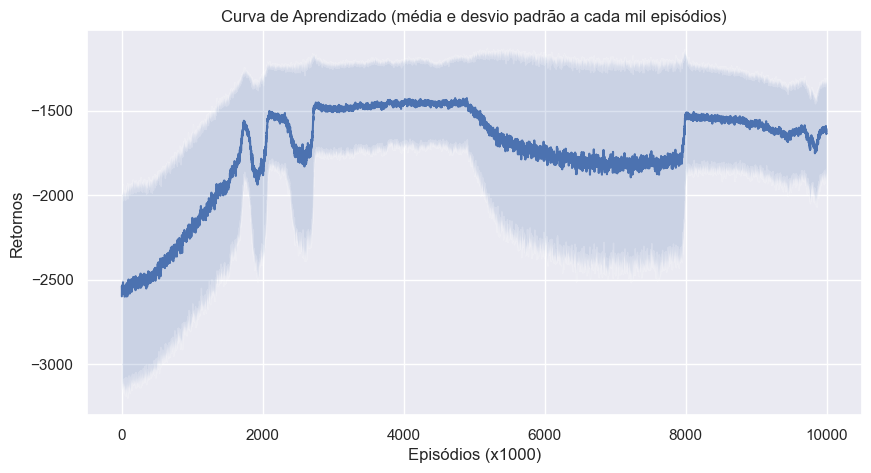

In [5]:
plt.figure(figsize=(10,5))
plt.plot(media_1000_episodios)
plt.fill_between(range(len(media_1000_episodios)), media_1000_episodios - desvio_1000_episodios, media_1000_episodios + desvio_1000_episodios, alpha=0.2)
plt.title('Curva de Aprendizado (média e desvio padrão a cada mil episódios)')
plt.ylabel('Retornos')
plt.xlabel('Episódios (x1000)')

In [12]:
import gymnasium as gym
from tqdm import tqdm
# import gym as old_gym
from gymnasium import spaces
from typing import Any, Optional
from collections import deque
from gymnasium.spaces import Discrete, MultiDiscrete

In [27]:
# Função de avaliação de política
def avalia_politica(ambiente_par, politica, n_episodios, seed=None):
    
    # Se foi passada uma string, assume-se que é um ambiente gym
    if isinstance(ambiente_par, str):
        ambiente_valid = gym.make(ambiente_par, render_mode="rgb_array")
        ambiente = ambiente_valid.env.P
    else: # caso contrário, assume-se que foi passado o MDP diretamete
        ambiente_valid = None
        ambiente = ambiente_par
    
    if ambiente:
        ambiente.seed(seed)
        retornos = []

        # for episodio in range(n_episodios):
        for episodio in tqdm(range(n_episodios), leave=False):
            estado, _ = ambiente.reset()            
            terminado = False
            retorno = 0
            while not terminado:
                acao = politica(estado)
                estado, recompensa, terminado, truncado, _ = ambiente.step(acao)
                retorno += recompensa            
            retornos.append(retorno)
        
        media_recompensa = np.mean(retornos)
        desvio_recompensa = np.std(retornos)

        return media_recompensa, desvio_recompensa, retornos
    else:
        print("ATENÇÃO: o ambiente não foi configurado corretamente!")
        return -1, []

In [18]:
def indice_estado_beergame(estado: int | list[int], obs_space) -> int:
    """ Converte um estado em um índice para o array Q 
        Faz a conta: 550*500*20*a + 500*20*b + 20*c + d
    """
    if isinstance(obs_space, MultiDiscrete):
        indice = estado[-1]
        fator = 1
        for i in range(len(estado)-2,-1,-1):
            fator *= obs_space.nvec[i+1]
            indice += fator*estado[i]
        return indice
    else:
        return estado

In [16]:
class BeerGame(gym.Env):

    # Método 'construtor'
    def __init__(self, seed : Optional[int] = None) -> None: 
       # 1-> Definindo o espaço de ações 
       self.pedido_max = 12 # Podem ser pedidos somente 20 cervejas por vez
       self.pedido_min = 0 # Não é possível realizar pedidos negativos (Isso não faz sentido!!)
       self.pedido_ini = 4 # O pedido inicial sempre é 4
       self.pedido_ant = self.pedido_ini # Essa variável 'pedido_ant' é uma variável auxiliar que guarda a informação sobre o pedido feito anteriormente (será atualizada a cada iteração)
       # Declarando espaço de ações:
       self.action_space = spaces.MultiDiscrete(np.array(4*[self.pedido_max]))
       
       # 2-> Definindo uma seed
       self.seed(seed) # Chamamos o método que cria uma seed
       
       # 3-> Definindo o espaço de estados
       self.estoque_ini = 12 # A quantidade inicial em estoque sempre é 12
       self.transporte_ini = 4 # A quantidade inicial em transporte sempre é 4
       self.capacidade_max = 20 # A capacidade máxima de estoque em qualquer um dos membros da cadeia de suprimentos
       self.capacidade_min = 0 # Não é possível realizar guardar uma quantidade de cerveja negativa (Isso não faz sentido!!)
       # Definindo o observation space: limites, tipo de espaço e forma
       self.observation_space = spaces.MultiDiscrete(np.array(12*[self.capacidade_max]+[self.pedido_max]))

       # 4-> Inicializando os arrays dos estoques, transporte e produção
       self.estoques = 4*[0] # Simples 4 vetores de 1 posição uma para cada (R, W, D, F)
       self.entrega_retailer = deque(2*[0]) # Fila com 2 posições Retailer - Transporte
       self.entrega_wholesailer = deque(2*[0]) # Fila com 2 posições Wholesaler - Transporte
       self.entrega_distributor = deque(2*[0]) # Fila com 2 posições Distributor - Transporte
       self.producao_factory = deque(2*[0]) # Fila com 2 posições Factory - Produção
       
       # 5-> Definimos os arrays com os valores iniciais correspondentes
       self._inicializar_cadeia()
       
       # 6-> Definimos os preços 
       self.custo_de_estoque = 0.5
       self.custo_de_backlog = 1
       
       # 6-> Definimos o oeríodo em que o BeerGame será rodado
       self.periodo_max = 50
       self.periodo_atual = 0 # Variável auxiliar será atualizada a cada iteração

    # Define os arrays com os valores iniciais correspondentes
    def _inicializar_cadeia(self) -> None:
       self.estoques = 4*[self.estoque_ini] # Estoques começam com 12 cervejas
       self.entrega_retailer = deque(2*[self.transporte_ini]) # Estão transportando 4 cervejas em cada slot de entrega
       self.entrega_wholesaler = deque(2*[self.transporte_ini]) # Estão transportando 4 cervejas em cada slot de entrega
       self.entrega_distributor = deque(2*[self.transporte_ini]) # Estão transportando 4 cervejas em cada slot de entrega
       self.producao_factory = deque(2*[self.transporte_ini]) # Estão produzindo 4 cervejas em cada slot de produção

    #   Esse método retorna um estado, ou seja, uma observação do estado, em que a 
    # posição 0 é estoque do Retailer e a posicao 11 é slot de producao da fábrica
    # a posição 12 é na verdade a informação sobre o pedido feito ao Retailer anteriormente
    def _montar_estado(self) -> list[int]:
       estado = 13*[0]
       estado[0] = self.estoques[0]
       estado[1] = self.entrega_retailer[0]
       estado[2] = self.entrega_retailer[1]
       estado[3] = self.estoques[1]
       estado[4] = self.entrega_wholesaler[0]
       estado[5] = self.entrega_wholesaler[1]
       estado[6] = self.estoques[2]
       estado[7] = self.entrega_distributor[0]
       estado[8] = self.entrega_distributor[1]
       estado[9] = self.estoques[3]
       estado[10] = self.producao_factory[0]
       estado[11] = self.producao_factory[1]
       estado[12] = self.pedido_ant       

       return estado

    # Esse método reseta o ambiente, reinicializando os arrays com os valores iniciais definidos no 'construtor'
    def reset(self) -> list[int]:
       self._inicializar_cadeia() # Reinicializa os arrays com os valores iniciais
       self.periodo_atual = 0 # Reinicia a contagem do período
       return np.array(self._montar_estado()), {} # retorna uma observação do estado inicial
    
    # Esse método executa a ação escolhida no ambiente e retorna uma observação do estado, recompensa, se o estado é terminal e uma informação
    def step(self, action : list[int]) -> tuple[list[int], float, bool, bool, dict]:
       self.periodo_atual += 1 # Cada vez que uma ação é tomada é considerado um novo período
       
       custo = 0 # Inicializamos o valor do custo
       self.pedido_ant = self.rand_generator.randint(self.pedido_max + 1) # Sorteamos um número (de 1 a 20) que será o número de cervejas solicitados pelo cliente ao Retailer
       
       # Chegaram os caminhões: Os pedidos feitos anteriormente que estavam aguardando nas filas de entrega é adicionado aos estoques
       self.estoques[0] += self.entrega_retailer.popleft()
       self.estoques[1] += self.entrega_wholesaler.popleft()
       self.estoques[2] += self.entrega_distributor.popleft()
       self.estoques[3] += self.producao_factory.popleft()
       
       # Decisão Retailer:
       if (self.estoques[0] >= self.pedido_ant):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[0] = self.estoques[0] - self.pedido_ant
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         custo += (self.pedido_ant - self.estoques[0])*self.custo_de_backlog 
         self.estoques[0] = 0 # E o estoque é zerado
       
       # Decisão Wholesaler:
       if (self.estoques[1] >= action[0]):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[1] = self.estoques[1] - action[0]
         # Como Wholesaler não lida diretamente com cliente ele manda transportar as unidades de cerveja: o número pedido é adicionado a fila
         self.entrega_retailer.append(action[0])
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         custo += (action[0] - self.estoques[1])*self.custo_de_backlog
         # A quantidade que tem estoque será então transportada: adiciona-se a fila
         self.entrega_retailer.append(self.estoques[1])
         self.estoques[1] = 0 # E o estoque é zerado

       # Decisão Distributor:
       if (self.estoques[2] >= action[1]):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[2] = self.estoques[2] - action[1]
         # Como Distributor não lida diretamente com cliente ele manda transportar as unidades de cerveja: o número pedido é adicionado a fila
         self.entrega_wholesaler.append(action[1])
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         custo += (action[1] - self.estoques[2])*self.custo_de_backlog
         # A quantidade que tem estoque será então transportada: adiciona-se a fila
         self.entrega_wholesaler.append(self.estoques[2])
         self.estoques[2] = 0 # E o estoque é zerado
       
       # Decisão Factory:
       if (self.estoques[3] >= action[2]):
         # O número de unidades estocadas é subtraído pelo pedido quando o estoque é maior ou igual ao pedido
         self.estoques[3] = self.estoques[3] - action[2]
         # Como Factory não lida diretamente com cliente ele manda transportar as unidades de cerveja: o número pedido é adicionado a fila
         self.entrega_distributor.append(action[2])
       else:
         # Quando pedido é maior cobra-se um custo de backlog a cada unidade de cerveja não atendida, esse custo é armazenado como recompensa
         custo += (action[2] - self.estoques[3])*self.custo_de_backlog
         # A quantidade que tem estoque será então transportada: adiciona-se a fila
         self.entrega_distributor.append(self.estoques[3])
         self.estoques[3] = 0 # E o estoque é zerado
       
       # Da início a produção do número de unidades pedidas a fábrica
       self.producao_factory.append(action[3])
       
       # Além dos custos de Backlog é adicionado o custo de estoque por cada unidade em estoque em (R, W, D, F) -> Perceba que nessa situação a recompensa é negativa
       custo += sum(self.estoques)*self.custo_de_estoque
       # BeerGame só termina quando é atinjido o 50º período
       terminado = self.periodo_atual == self.periodo_max
       truncado = False # Não há limite de tempo para o BeerGame, logo não há truncamento

       # A recompensa será o negativo do custo, pois o agente tenta maximizar a recompensa e, logo,
       # minimizará o custo
       recompensa = -custo

       return np.array(self._montar_estado()), recompensa, terminado, truncado, {} # Retorna-se a observação do estado, a recompensa, se é estado terminal  

    # Esse método imprime uma observação do estado
    def render(self, mode : str ="human") -> Any: # opcional
       print(self._montar_estado())

    # Esse método close fecha todos os recursos abertos que foram usados pelo ambiente. No nosso caso não foi preciso implementá-lo
    def close(self) -> None: # opcional
       pass
    
    #   Cria uma seed aleatória para iteração: afeta diretamente os pedidos aleatórios do suposto cliente
    # Dessa forma a seed é utilizada quando deseja repetir um certo cenário no ambiente e testá-lo de diferentes formas
    def seed(self, seed=None) -> None:
      self.rand_generator = np.random.RandomState(seed)
      self.action_space.seed(seed)

# %%
class BeerGameSimplificado(BeerGame):
  
  def __init__(self,  seed : Optional[int] = None) -> None:
        super().__init__()
        
        # Reescrevendo a variável 'action_space' para aceitar somente 1 ação:
        self.action_space = spaces.Discrete(20)

        # Reescrevendo a variável 'observation_space' para ter visão somente do retailer
        self.observation_space = spaces.MultiDiscrete(np.array(3*[self.capacidade_max]+[self.pedido_max]))

  def step(self, action : int) -> tuple[list[int], float, bool, bool, dict]:
        # Recebe uma única ação e cria uma lista com a ação replicada para então chamar o método da Classe Pai
        acao = [action, action, action, action]
        
        return super().step(acao)

  def _montar_estado(self) -> list[int]:
    estado = super()._montar_estado()
    
    # Retorna apenas as informações do retailer e a demanda do cliente
    estado = estado[:3] + [estado[-1]]

    # Usa np.clip para garantir que o estado não passa dos valores máximos do observation_space
    estado = np.clip(estado, 0, self.observation_space.nvec-1)
    
    return estado

In [36]:
seed = np.random.randint(0, 1000)
seed

415

In [39]:
beer_game = BeerGameSimplificado(seed=10)

print('\n\nTestando função de avaliação:')
politica = lambda s : pi[indice_estado_beergame(s,beer_game.observation_space)]
media, desvio, retornos = avalia_politica(beer_game, politica, n_episodios = 30, seed=seed)
print(f'media = {media}')
print(f'desvio = {desvio}')
print(f'retorno = {retornos}')



Testando função de avaliação:


media = -1582.0666666666666
desvio = 198.42310573340214
retorno = [-1686.5, -1558.5, -2106.5, -1236.5, -1390.5, -1713.0, -1989.0, -1378.0, -1650.5, -1838.0, -1687.5, -1501.5, -1329.5, -1255.0, -1689.0, -1531.5, -1479.5, -1486.5, -1408.5, -1584.0, -1539.0, -1778.5, -1617.0, -1624.0, -1721.0, -1533.0, -1825.0, -1516.5, -1395.5, -1413.0]


In [40]:
print('\n\nTestando função de avaliação:')
politica_aleatoria = lambda s : beer_game.action_space.sample()
media_pa, desvio_pa, retornos_pa = avalia_politica(beer_game, politica_aleatoria, n_episodios = 30, seed=seed)
print(f'media_pa = {media_pa}')
print(f'desvio_pa = {desvio_pa}')
print(f'retorno_pa = {retornos_pa}')



Testando função de avaliação:


media_pa = -2702.45
desvio_pa = 508.2894410012206
retorno_pa = [-3043.5, -2483.5, -2891.5, -1936.0, -3181.5, -2431.0, -2281.0, -2733.0, -2789.5, -2655.0, -2243.0, -3346.0, -3582.0, -2970.0, -2517.0, -4167.5, -3213.0, -2647.5, -2382.5, -2010.0, -2655.0, -2180.5, -2253.0, -2433.5, -3102.5, -2334.5, -2743.5, -1836.5, -3318.0, -2712.5]


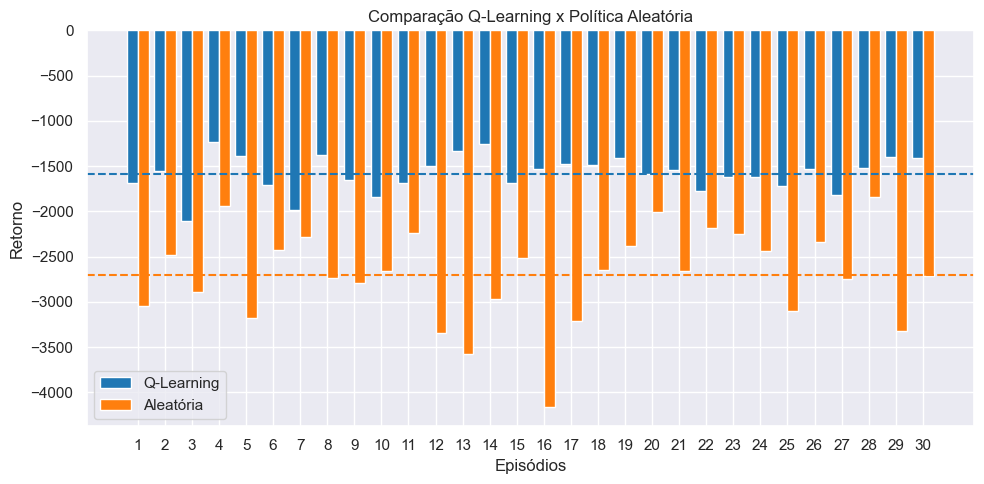

In [53]:
politicas = ['Q-Learning', 'Agente Aleatório']

# Gerando dados de exemplo (vetores grandes)
num_episodios = 30
num_politicas = len(politicas)

cores = {0:'tab:blue', 1:'tab:orange'}

dados = []
dados.append(retornos)
dados.append(retornos_pa)

valores_medios = []
valores_medios.append(media)
valores_medios.append(media_pa)

# Labels para os vetores
grupos = [f'{i+1}' for i in range(num_episodios)]

# Criando o gráfico de barras múltiplos com a linha das médias
# plt.figure()
fig, ax1 = plt.subplots(figsize=(10,5))

# Plotando as barras para cada vetor
x = np.arange(len(grupos))
width = 0.8/num_politicas
for i in range(len(dados)):
    ax1.bar(x + i * width, dados[i], width, label=politicas[i], color=cores[i])

ax1.set_xlabel('Episódios')
ax1.set_ylabel('Retorno')
ax1.set_title('Comparação Q-Learning x Agente Aleatória')
ax1.set_xticks(x + width * (len(dados) - 1) / 2)
ax1.set_xticklabels(grupos)
ax1.legend()

# Adicionando a linha das médias
for i in range(len(valores_medios)):
   ax1.axhline(valores_medios[i], linestyle='--', label='Média', color=cores[i])

fig.tight_layout()
plt.show()